# Vinho Verde: Wine Quality Analysis

## Introduction

Wine is a type of alcoholic beverage made from the fermentation of grape juice. There are many factors which determine the final quality of wine: The volatile acidity is usually the measure of acetic acid in wine, if the VA is above a certain threshold the wine is considered spoiled and will taste like vinegar. On the other hand, citric acid is used to increase acidity and enhance the flavour of the wine. The residual sugar in wine is the leftover sugar from the grapes after the fermentation process; higher sugar levels increase the sweetness of the wine. While the sugar controls sweetness, chloride contributes to the saltiness of wine, more sodium chloride creates a saltier beverage. PH is essential to wine quality, low pH makes the taste of wine crisp and tart, whereas a high pH results in susceptibility to bacterial growth. Along with this, higher sulphate content also decreases the quality of wine, making it taste duller. 
 
**How do different variables change the overall quality of the wine? Are certain variables more impactful and important than others? Do certain variables have a threshold after which the quality sharply decreases?**

The goal of the project will be to answer these two questions by making a scatter plot graph that compares the wines on both an individual and group level. We will also do a classification of the wines in order to better visualize their quality. Finally, the alcohol content affects its flavour, texture, and overall quality. All of these factors must be considered when trying to answer our question. 

The dataset which will be used is data collected by Paulo Cortez, from the University of Minho in Portugal. He, along with A. Cerdeira, F. Almeida, T. Matos and J. Reis, Viticulture Commission of the Vinho Verde Region(CVRVV), Porto, Portugal collected data about the Vinho Verde wines that have been grown in Northern Portugal. This dataset (from 2009) specifically only takes into account the physicochemical qualities of the wine such as acidity, pH,sulphates, residual sugars and more however it ignores things such as grape type, wine brand, selling price, or other things that could be left as a subjective preference of each person.

**Citation:**

P. Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009

## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We use the `read_csv2()` function to read the file from the web.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_red <- read_csv2(url)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): volatile acidity, citric acid, chlorides, density, sulphates
dbl (2): total sulfur dioxide, quality

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We clean the column names to remove spaces using `make.names`, then change the datatypes of columns to dbl using `mutate()` and `as.double()` and finally remove the columns we dont wish to use using `select()`.

In [3]:
colnames(wine_red) <- make.names(colnames(wine_red))

wine_red <- wine_red |>
            mutate(across(fixed.acidity:sulphates, as.double)) |>
            select(-total.sulfur.dioxide, -pH, -alcohol, -density)

wine_red

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
74,0.70,0.00,19,0.076,11,0.56,5
78,0.88,0.00,26,0.098,25,0.68,5
78,0.76,0.04,23,0.092,15,0.65,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
63,0.510,0.13,23,0.076,29,0.75,6
59,0.645,0.12,2,0.075,32,0.71,5
6,0.310,0.47,36,0.067,18,0.66,6


Splitting the dataset into training and testing sets.

In [4]:
wine_split <- initial_split(wine_red, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

wine_train

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
78,0.88,0.00,26,0.098,25,0.68,5
78,0.76,0.04,23,0.092,15,0.65,5
74,0.70,0.00,19,0.076,11,0.56,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
74,0.36,0.30,18,0.074,17,0.70,8
7,0.56,0.17,17,0.065,15,0.68,7
67,0.32,0.44,24,0.061,24,0.80,7


**1.**
Checking how many NA values are present in each column using the `apply()` function. 

In [5]:
apply(X = is.na(wine_train), MARGIN = 2, FUN = sum)

fixed.acidity    volatile.acidity         citric.acid      residual.sugar 
                  0                   0                   0                   0 
          chlorides free.sulfur.dioxide           sulphates             quality 
                  0                   0                   0                   0

Since there are no NA values in any of the columns, it is clear that all columns have 1198 rows of observations.

**2.**
Summarizing the means and ranges of all variables using `summarize()` and `map_df()`.

In [6]:
# mean_summary <- summarize(wine_train, across(fixed.acidity:sulphates, mean))
mean_summary <- wine_train |>
                select(-quality) |>
                map_df(mean)

range_summary <- summarize(wine_train, across(fixed.acidity:sulphates, range))

mean_summary
range_summary

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
74.57679,0.5285225,0.2706678,26.56177,0.08808681,16.59098,0.6632805


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,0.12,0,2,0.012,1,0.33
159,1.58,1,655,0.611,375,2.00


The range data gives us the minimum and maximum values for each column in the database.

**3.**
Finding out means of predictors that correspond to each level in the quality scale. This will help us later to check if our prediction of wine quality makes logical sense.

In [7]:
group_by(wine_train, quality) |>
        summarize(across(fixed.acidity:sulphates, mean))

quality,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,85.28571,0.9514286,0.1714286,85.00000,0.09714286,11.85714,0.5614286
4,71.70732,0.7064634,0.1639024,26.14634,0.09639024,12.48780,0.6182927
5,73.15686,0.5774118,0.2457843,25.66275,0.09482549,17.11765,0.6254706
6,74.28452,0.4966213,0.2700628,22.67364,0.08459205,15.92259,0.6789749
7,80.77703,0.4035135,0.3805405,40.07432,0.07529730,18.58784,0.7491216
8,73.78571,0.4257143,0.3985714,21.21429,0.06828571,13.50000,0.7800000


From this table, we can see that a quality 4 wine for example corresponds to an average value of 23.5 in residual sugar.

**4.**
Finding overall summary of dataset using `summary()`.

In [8]:
summary(wine_train)

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   :  5.00   Min.   :0.1200   Min.   :0.0000   Min.   :  2.00  
 1st Qu.: 68.00   1st Qu.:0.3900   1st Qu.:0.0900   1st Qu.: 17.00  
 Median : 77.00   Median :0.5200   Median :0.2550   Median : 21.00  
 Mean   : 74.58   Mean   :0.5285   Mean   :0.2707   Mean   : 26.56  
 3rd Qu.: 89.00   3rd Qu.:0.6400   3rd Qu.:0.4300   3rd Qu.: 26.00  
 Max.   :159.00   Max.   :1.5800   Max.   :1.0000   Max.   :655.00  
   chlorides       free.sulfur.dioxide   sulphates         quality     
 Min.   :0.01200   Min.   :  1.00      Min.   :0.3300   Min.   :3.000  
 1st Qu.:0.07000   1st Qu.:  7.00      1st Qu.:0.5500   1st Qu.:5.000  
 Median :0.07900   Median : 14.00      Median :0.6200   Median :6.000  
 Mean   :0.08809   Mean   : 16.59      Mean   :0.6633   Mean   :5.635  
 3rd Qu.:0.09075   3rd Qu.: 22.00      3rd Qu.:0.7400   3rd Qu.:6.000  
 Max.   :0.61100   Max.   :375.00      Max.   :2.0000   Max.   :8.000  

## Visualization

We use the `ggplot` function to graph how each variable contributes to each quality. 
Then we used `plot_grid` function to group each graph together to help us better visualize and compare our data set. 

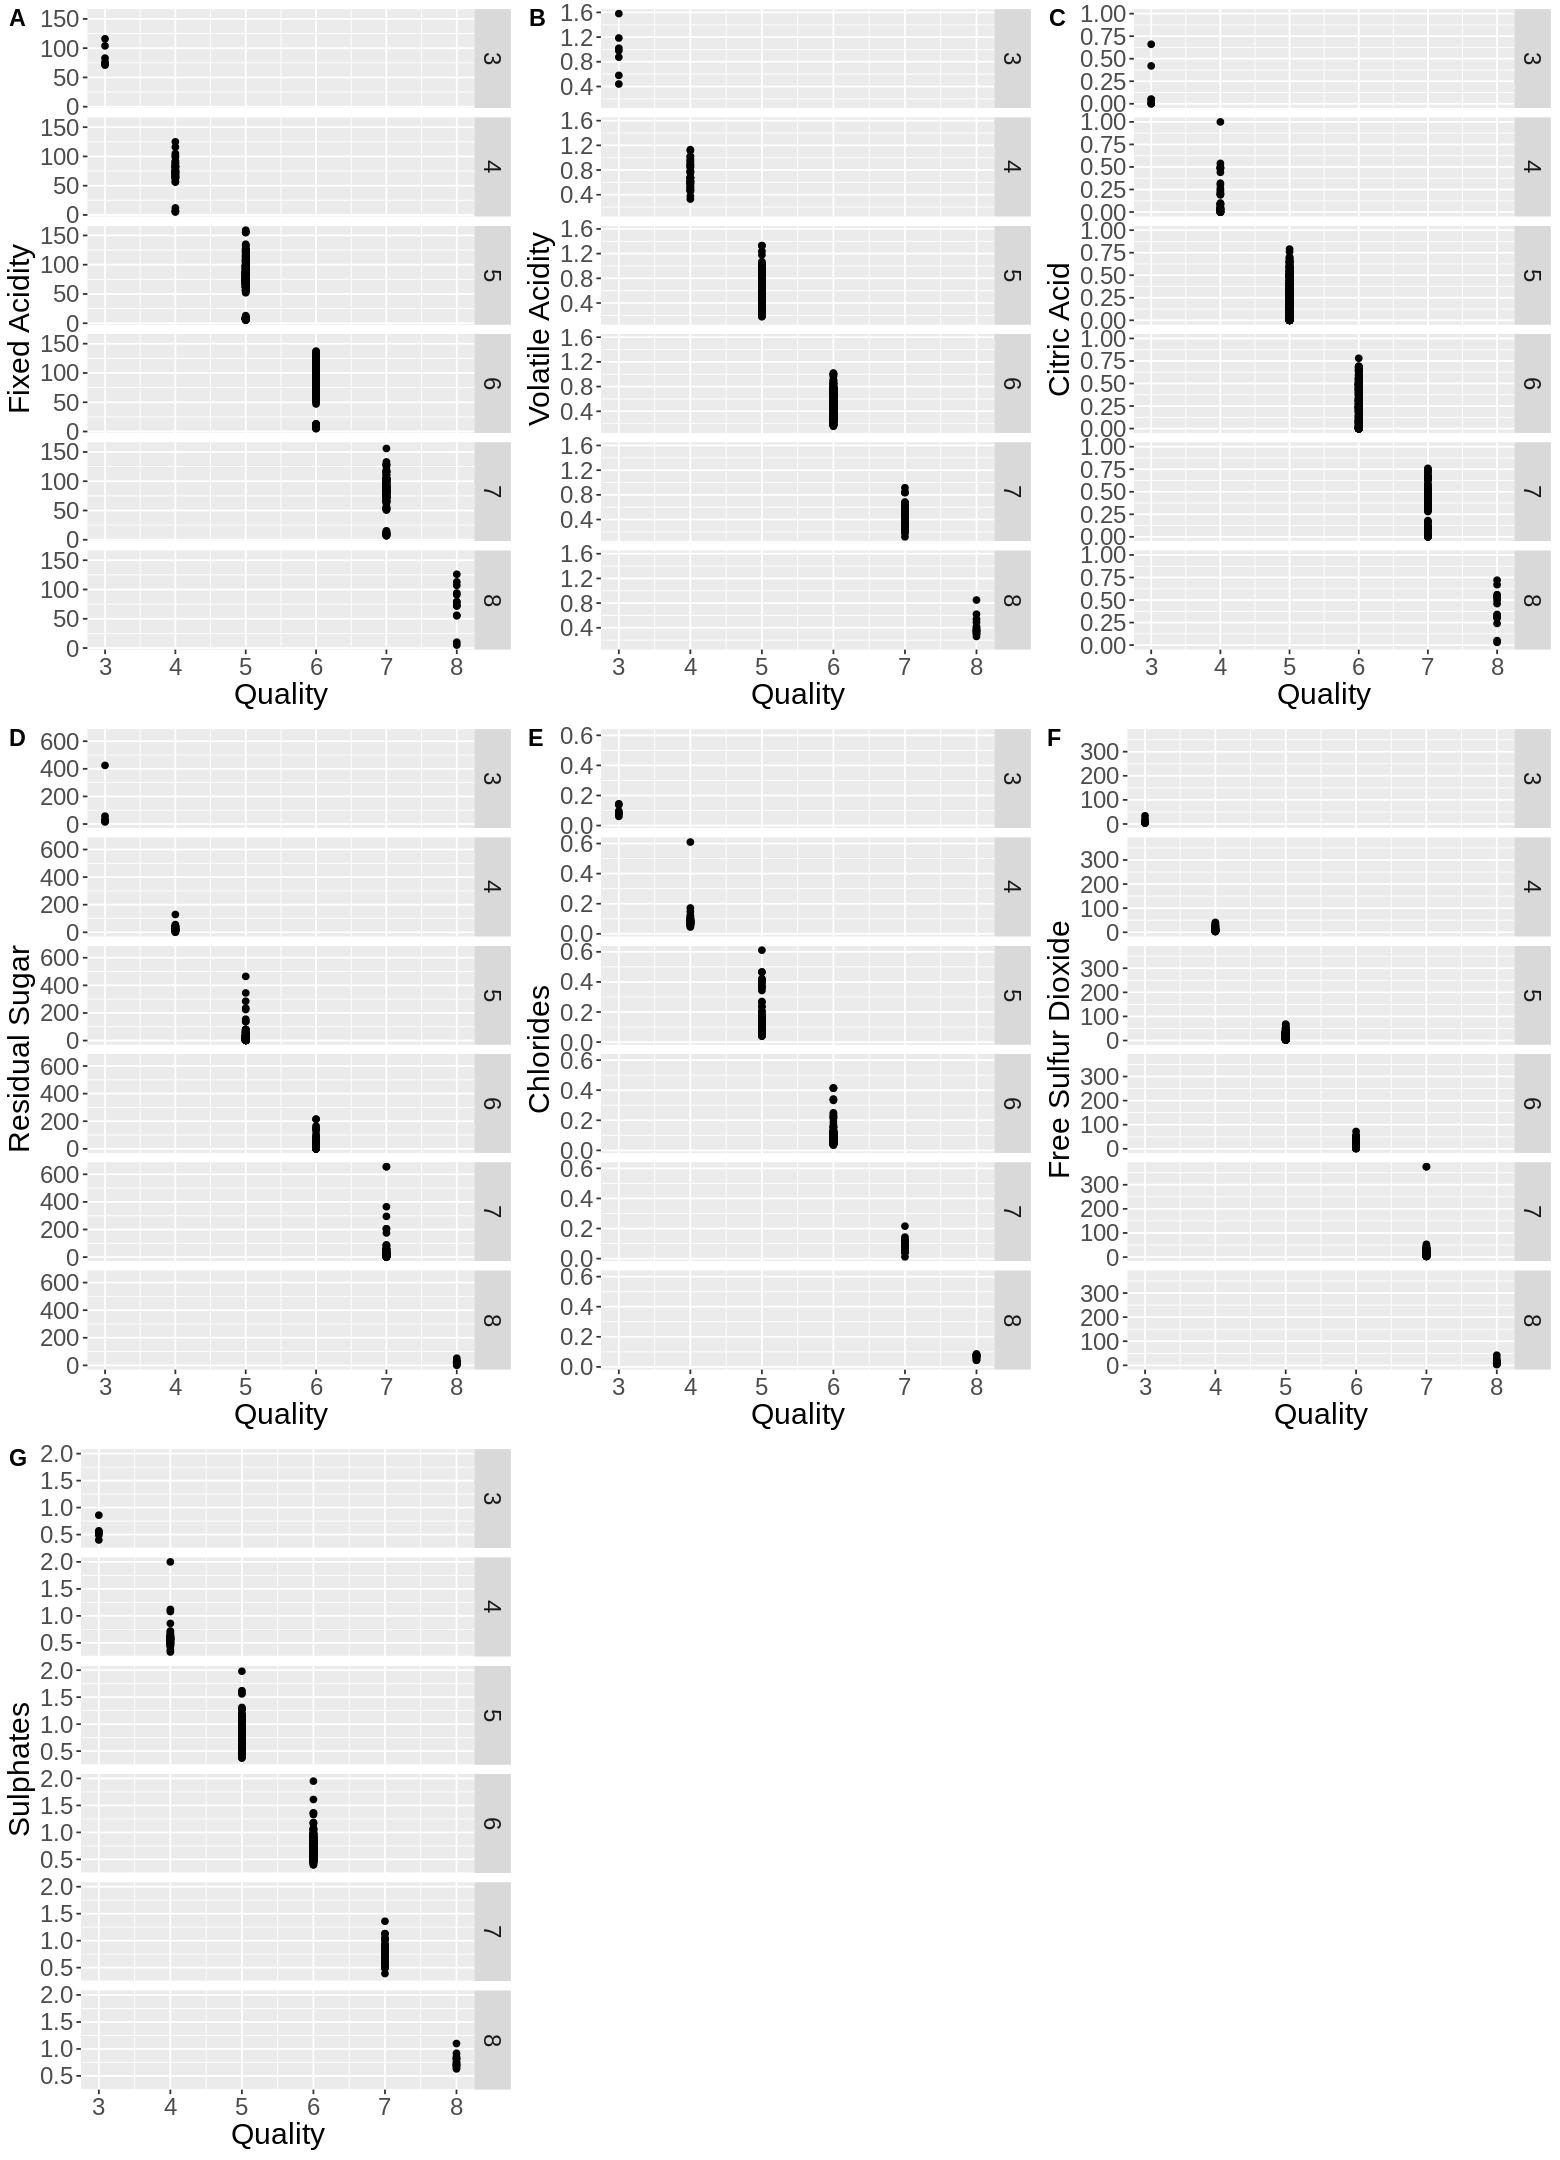

In [10]:
fixed_acidity_plot <- ggplot(wine_train, aes(x = fixed.acidity, y = quality)) +
                geom_point() +
                facet_grid(rows = vars(quality))+
                labs(x = "Fixed Acidity", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

volatile_acidity_plot <- ggplot(wine_train, aes(x = volatile.acidity, y = quality)) +
                geom_point() +
                facet_grid(rows = vars(quality))+
                labs(x = "Volatile Acidity", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

citric_acid_plot <- ggplot(wine_train, aes(x = citric.acid, y = quality)) +
                geom_point() +
                facet_grid(rows = vars(quality))+
                labs(x = "Citric Acid", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()
 
residual_sugar_plot <- ggplot(wine_train, aes(x = residual.sugar, y = quality)) +
                geom_point() +
                facet_grid(rows = vars(quality))+
                labs(x = "Residual Sugar", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

chlorides_plot <- ggplot(wine_train, aes(x = chlorides, y = quality)) +
                geom_point() +
                facet_grid(rows = vars(quality))+
                labs(x = "Chlorides", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

free_sulfur_dioxide_plot <- ggplot(wine_train, aes(x = free.sulfur.dioxide, y = quality)) +
                geom_point() +
                facet_grid(rows = vars(quality))+
                labs(x = "Free Sulfur Dioxide", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

sulphates_plot <- ggplot(wine_train, aes(x = sulphates, y = quality)) +
                geom_point() +
                facet_grid(rows = vars(quality))+
                labs(x = "Sulphates", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

options(repr.plot.width = 13, repr.plot.height = 18)

plot_grid(fixed_acidity_plot, volatile_acidity_plot, citric_acid_plot, residual_sugar_plot, chlorides_plot, free_sulfur_dioxide_plot, sulphates_plot,  
          labels = c("A", "B", "C", "D", "E", "F", "G"),
          ncol = 3, nrow = 3)

From reading these graphs, we can collect many useful information regarding to how each variables changes the overall quality of the wine. For example, the fixed acidity plot shows us that wines with quality of 3 contains amount ranging from 70 to 120, while wines with quality of 4 ranges from 0 to 125, and so on. 

## Method
 We will conduct our data analysis by creating a histogram graph and individually assessing how each variable changes the quality of the wine. We will also be removing 4 columns that we believe have little to no change throughout all of the data. For example fixed acidity is always going to be fixed and as such will have no change. This means that it is completely useless to have an unchanging variable within our data. We will also be removing density, free and total sulfur dioxide as the difference in values is very small and as such will not have much of a noticeable impact on the quality of the wine. All 8 other columns that we will be using however all have significant impact upon the quality of the wine and as such it is extremely important to see how their variability changes the wine and which one has the biggest impact with the smallest change.
One way that we will visualize the result is to make a histogram graph. On the y-axis we will have the quality of the wine on a 1-10 scale and on the x-axis we will have our other variable that it is being compared to i.e. residual sugar, sulphates, volatile acidity etc. This will allow us to have many graphs that show how each variable changes the overall quality of the wine.

## Expected Outcomes and Significance
1. **What do we expect to find?**

We expect to find which variables have the biggest impact on the wine and whether or not certain variables are simply more impactful than others. It would also be interesting to see if a certain variable has a “breaking point” or a spot where the quality will sharply drop as soon as it hits that threshold. For example if after volatile hits 0.4 we see exponential change in the wine quality. Lastly, we would like to see what the ideal level of each variable is in order to achieve the perfect (or closest to it) vinho verde.

2. **What impact could such findings have?**

Determining wine quality can promote wine testing and ensure safety within not only wine sectors, but the overall food and beverage industry.  Being able to determine the quality of a commodity can inform consumers and motivate sellers to consistently improve their practice and uphold a certain standard of quality. Furthermore, the quality of wine can serve as a reflection of its contents, which provide an important insight as to whether the wine is safe to drink and follows food health and safety guidelines. 

3. **What future questions could this lead to?**

Knowing which variables are more impactful and which ones need to be focused on more can be an important tool for winemakers in order to perfect their craft. If they know that pH is a particularly sensitive variable that quality shifts sharply with them a point can be made in order to focus on refining the winemaking process to ensure the stability of pH throughout. This can also be used the other way where knowing that certain variables can be compromised ex. citric acid then winemakers can focus less on making something that is super stable in its citric acid in favour of a process that increases/decreases the level of citric acid in order to perfect the level of pH and increase the quality of their wine. 
